# Batch Isochrones

Produces a .geojson file for each origin. Each file has features for default travel time cutoffs (0 minutes to 90 minutes, at 15 minute increments) and percentiles.

Requires a Conveyal token (e.g. 'bearer 1234abcd...') saved at config/.auth, and an appropriate profile request template copied from Advanced Settings in the analysis panel of the Conveyal Analysis user interface.

## Setup

In [1]:
import requests
import numpy
import json
import matplotlib.pyplot as plt
import geojsoncontour
import geojson
import rasterio
import shapely_geojson
from shapely.geometry import mapping, shape, MultiPolygon

url = 'https://api.conveyal.com/api/analysis'

# Authorization header copied from DevTools Network request
token = open('config/.auth').readline().strip()

# Copy from Advanced Settings in the analysis panel
# Ensure that the scenario, variantNumber, and other parameters are set correctly
profileRequest = json.load(open('config/profile-requests/london-demo.json'))

# Load from a JSON array with properties "name", "fromLat", and "fromLon" for each point
origins = json.load(open('config/origins.json'))

isochroneIntervals = range(0, 105, 15)

percentileValues = [50] # For all available percentile values, use  [5, 25, 50, 75, 95]

headers = {
    'Authorization': token,
    'Accept': 'image/tiff'
}

## Download and processing

Processing Palestra


/home/ansons/.local/lib/python3.5/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Processing St James Park


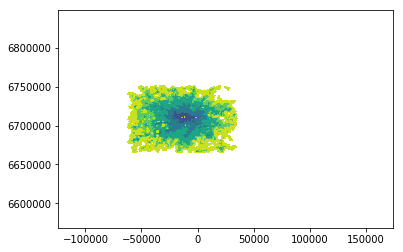

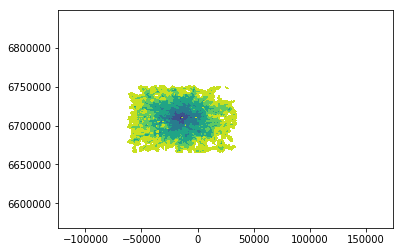

In [2]:
# Loop over origins
for origin in origins:
    originName = origin['name']
    profileRequest['fromLat'] = origin['fromLat']
    profileRequest['fromLon'] = origin['fromLon']
    
    print('Processing ' + originName)
    
    # Request a tiff from Conveyal Analysis
    r = requests.post(url, headers = headers, json = profileRequest, verify = False)
    
    if r.status_code == 202:
        print('Routing engine starting, try again in a few minutes.')
    
    elif r.status_code == 403:
        print('Unauthorized access. Your authorization token may be invalid or expired.')
        
    elif r.status_code != 200:
        print('Error: ' + r.text)
        
    else:
        # Save response from Conveyal Analysis to a local .tiff file
        with open(originName + '.tiff', 'wb') as f:
            for chunk in r.iter_content(chunk_size=128):
                f.write(chunk)
                
        tiff = rasterio.open(originName + '.tiff')

        crsEpsg = tiff.crs.to_string()

        # Set up tiff processing        
        latRange = numpy.arange(tiff.bounds.top, tiff.bounds.bottom, -tiff.res[1])
        lonRange = numpy.arange(tiff.bounds.left, tiff.bounds.right, tiff.res[0])

        isochroneJson = {
            'crs': {'type':'name','properties':{'name': crsEpsg}},
            'type': 'FeatureCollection',
            'features': []
        }    
        
        figure = plt.figure().add_subplot(111)
        
        # Loop over percentile values
        for percentileIndex in range(0, len(percentileValues)):

            values =  tiff.read(percentileIndex + 1) # GDAL 1-based indexing
            values[values == 0] = 120

            contourf = figure.contourf(lonRange, latRange, values, levels = isochroneIntervals)
            contours = geojsoncontour.contourf_to_geojson(contourf = contourf, ndigits = 3)
            contourJson = json.loads(contours)
            
            # Loop over the travel time cutoff values 
            # (one set of features per element of isochrone intervals)
            for i in range(0, len(contourJson['features'])):

                feature = contourJson['features'][i]
                cutoff = list(isochroneIntervals)[i+1]

                isochroneFeature = {
                    'type': 'Feature',
                    'properties': {
                        'minutes': cutoff,
                        'percentile': percentileValues[percentileIndex]
                    }
                }

                # The next two steps remove shapes with no coordinates, zero-area artifacts, 
                # and self-intersections
                nextBand = shape({
                    'type': 'MultiPolygon', 
                    'coordinates': list(filter(
                        lambda coords: (len(coords) > 0), 
                        feature['geometry']['coordinates']))
                })

                nextBand = MultiPolygon(list(filter(lambda poly: (poly.area > 0), nextBand))).buffer(0)

                # countourf returns the area between the requested intervals (e.g. a bandreachable in 
                # between 15 and 30 minutes). Union this band with the previous ones to show the cumulative
                # area reachable.
                if i > 0:
                    nextBand = nextBand.union(shape(isochroneJson['features'][i - 1]['geometry']))

                isochroneFeature['geometry'] = json.loads(shapely_geojson.dumps(nextBand))
                isochroneJson['features'].append(isochroneFeature)

            # Write out the various travel time cutoff and percentile values to a single file per-origin.
            with open(originName + '.geojson', 'w') as f:
                json.dump(isochroneJson, f)